In [2]:

# Example notebook to parse and plot Summit CPC data.
# By Heather Guy, 2019-11-20

# Import useful packages.

import matplotlib
#matplotlib.use('Agg')
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import matplotlib.colors as colors
import os
import glob
from scipy import io

import sys
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from ace_parse import *
from utils import * 


In [3]:
# Function to parse CPC data

def get_cpc(start,stop,d_loc):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    CPC_out = pd.DataFrame(columns=['c/cm3', 'QC'])
    for date in f_date_list:
        f = d_loc + r'CPC_%s'%(str(date.date()))
        
        try:
            data = pd.read_csv(f,parse_dates=[0],index_col=[0])
        except:
            print('No data for %s'%str(date.date()))
            continue

        CPC_out = CPC_out.append(data,sort=True)    
    
    # Get rid of any duplicates
    CPC_out = CPC_out[~CPC_out.index.duplicated()]
    
    # Fill any missing minutes with nans
    new_index = pd.date_range(start,stop-pd.Timedelta(minutes=1) , freq='min')
    CPC_out = CPC_out.reindex(new_index)
    
    # Crop to datetime
    CPC_out=CPC_out[start:stop]
    
    return CPC_out
    

In [8]:
# Get the data

#2019,7,2,0 —> 2019,7,3,18
#2019,8,9,17 —> 2019,8,10,8
#2019,11,20,7 —> 2019,11,22,7


d_loc = '/Volumes/Data/ICECAPSarchive/ace/processed/CPC/'
d1 = dt.datetime(2019,8,8,12,0)
d2 = dt.datetime(2019,8,11,12,0)

cpc = get_cpc(d1,d2,d_loc)
cpc_qc = cpc.copy()
cpc_qc['c/cm3'][cpc['QC']==0]=np.nan

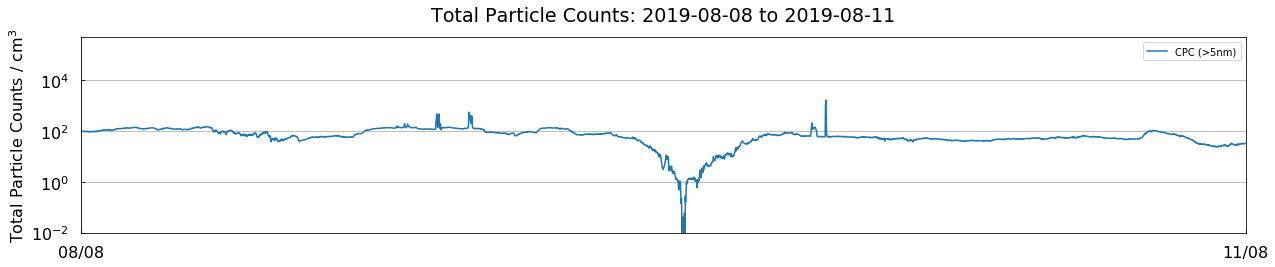

In [9]:
# Plot total counts No QC

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(cpc.index,cpc['c/cm3'], label='CPC (>5nm)')   
ax.set_ylim(0.01,500000)
ax.set_ylabel('Total Particle Counts / cm$^3$')
ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(md.DayLocator(interval=30))
ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')


In [10]:
# Plot total counts with QC

monthly_median = cpc_qc.resample('1M').median()
mm_dates = monthly_median.index - pd.Timedelta(days=15)
monthly_median.iloc[12] = np.nan
monthly_median.iloc[13] = np.nan

IndexError: single positional indexer is out-of-bounds

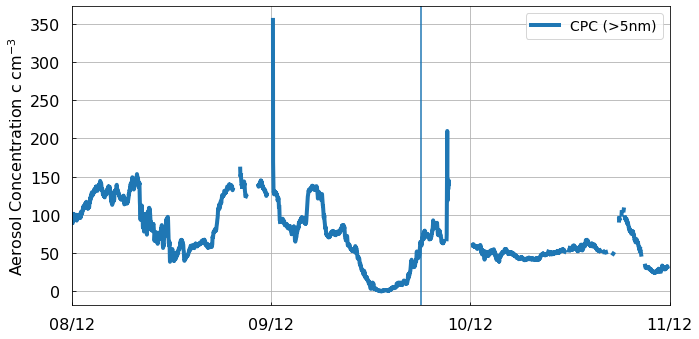

In [13]:
from matplotlib import rcParams
# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='12'
rcParams['ytick.major.pad']='12'

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(cpc_qc.index,cpc_qc['c/cm3'], label='CPC (>5nm)',lw=4)   
#ax.semilogy(cpc_qc.index,cpc_qc['c/cm3'], label='CPC (>5nm)',lw=2)
#ax.semilogy(cpc_qc['c/cm3'].resample('1D').median(),lw=2,label='Daily median')
#ax.semilogy(mm_dates,monthly_median['c/cm3'],lw=4, label='Monthly median')



#ax.set_ylim(0,800)
ax.set_ylabel('Aerosol Concentration c cm$^{-3}$')
#ax.set_title('QCd Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))

ax.xaxis.set_major_formatter(md.DateFormatter('%d/%H'))
#ax.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
ax.xaxis.set_major_locator(md.HourLocator(interval=24))


# Plot low aerosol line
#ax.axhline(10,c='tab:orange',ls='--',lw=3,alpha=0.6,label='10 c/cm3')
#ax.axhline(1,c='tab:orange',ls='-',lw=3,alpha=0.6,label='1 c/cm3')
#ax.axhline(np.mean(cpc_qc['c/cm3']),c='grey',ls='-',lw=2,alpha=0.6,label='mean: %s'%np.mean(cpc_qc['c/cm3']))
ax.axvline(dt.datetime(2019,8,10,6))

ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=14)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')

# percent of time below 10 c/cm3
(len(cpc_qc[cpc_qc['c/cm3']<10]) / len(cpc_qc['c/cm3'])) * 100

In [20]:
# Aerosol counts frequency plot (histogram)

nbins = 1000
bins = np.logspace(0.001,4,nbins)
#widths = np.linspace(1,4,nbins-1)
hist = np.histogram(cpc_qc['c/cm3'], bins=bins)[0]



In [21]:
mode = bins[np.where(hist == max(hist))[0][0]]
mean = np.mean(cpc_qc['c/cm3'])

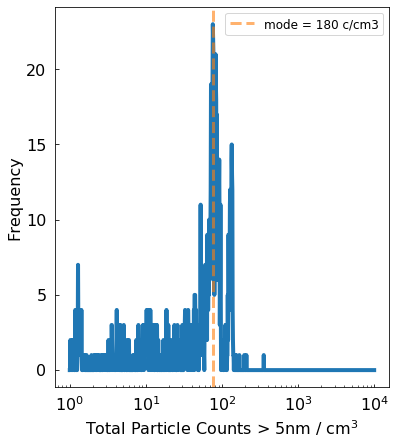

In [50]:
fig = plt.figure(figsize=(6,7))
ax1 = fig.add_subplot(111)
#ax1.grid(True)


#ax1.bar(bins[:-1],hist,width=widths,align='edge')
ax1.plot(bins[:-1],hist, lw=4)
ax1.axvline(mode,c='tab:orange',ls='--',lw=3,alpha=0.6,label='mode = 180 c/cm3')
ax1.set_xscale('log')

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Total Particle Counts > 5nm / cm$^3$')

#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
#ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
#ax.xaxis.set_major_locator(md.DayLocator(interval=30))
#ax1.set_xlim(0,10000)
#ax1.set_ylim(0,2100)
ax1.legend(loc='best',fontsize=12)
#plt.bar(bins[:-1],hist,align='edge')

In [16]:
# Print day times where CPC counts go < 0.1
# Dates when concentrations less than.... 
lim = 1
time_lim = 1 # hours


low_count_dates = cpc_qc[cpc_qc['c/cm3']<lim].index

In [17]:
starts = []
stops = []
starts.append(low_count_dates[0])
a = low_count_dates[0]

for i in range(1,len(low_count_dates)):
    if low_count_dates[i] - a > pd.Timedelta(hours=time_lim):
        stops.append(low_count_dates[i-1])
        starts.append(low_count_dates[i])
        
    a = low_count_dates[i]
    
stops.append(low_count_dates[-1])


# Make sure the events last at least 10 mins
long_starts=[]
long_stops=[]
for i in range(0,len(starts)):
    if stops[i] - starts[i] > pd.Timedelta(hours=time_lim):
        long_starts.append(starts[i])
        long_stops.append(stops[i])
        

In [83]:
len(long_starts)

9

In [84]:
len(long_stops)

9

In [18]:
starts

[Timestamp('2019-02-20 08:49:00'),
 Timestamp('2019-02-26 07:30:00'),
 Timestamp('2019-02-26 11:15:00'),
 Timestamp('2019-03-02 18:46:00'),
 Timestamp('2019-03-02 19:57:00'),
 Timestamp('2019-03-02 23:38:00'),
 Timestamp('2019-03-06 08:53:00'),
 Timestamp('2019-03-08 06:31:00'),
 Timestamp('2019-03-08 09:38:00'),
 Timestamp('2019-03-13 13:41:00'),
 Timestamp('2019-07-14 13:04:00'),
 Timestamp('2019-08-10 00:56:00'),
 Timestamp('2019-09-15 13:32:00'),
 Timestamp('2019-10-03 11:27:00'),
 Timestamp('2019-10-05 11:24:00'),
 Timestamp('2019-11-21 05:54:00'),
 Timestamp('2019-11-21 09:26:00'),
 Timestamp('2019-12-03 17:48:00'),
 Timestamp('2019-12-04 13:04:00')]

In [19]:
stops

[Timestamp('2019-02-20 15:09:00'),
 Timestamp('2019-02-26 09:38:00'),
 Timestamp('2019-02-26 22:43:00'),
 Timestamp('2019-03-02 18:46:00'),
 Timestamp('2019-03-02 20:19:00'),
 Timestamp('2019-03-02 23:38:00'),
 Timestamp('2019-03-06 13:27:00'),
 Timestamp('2019-03-08 08:22:00'),
 Timestamp('2019-03-08 13:12:00'),
 Timestamp('2019-03-13 13:41:00'),
 Timestamp('2019-07-14 13:04:00'),
 Timestamp('2019-08-10 02:09:00'),
 Timestamp('2019-09-15 13:32:00'),
 Timestamp('2019-10-03 11:27:00'),
 Timestamp('2019-10-05 11:24:00'),
 Timestamp('2019-11-21 08:18:00'),
 Timestamp('2019-11-21 10:46:00'),
 Timestamp('2019-12-03 17:48:00'),
 Timestamp('2019-12-04 13:04:00')]